# TP 2

## Ejercicio 1: Recomendación de vinos.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt



### A) Descargar los Datos

In [2]:
#Importo los datos de la csv

from google.colab import files
wine = files.upload()

Saving wine.csv to wine.csv


### B) Variables Independientes y Dependientes

- Definimos las variables independientes como las características de los vinos que sólo dependen del input.

- Definomos las variables dependientes como las características de los vinos que dependen de otras características.


---



 **Variables Independientes**:

Alcohol, Malic_Acid, Ash, Ash_Alcanity, Magnesium, Total_Phenols, Flavanoids, Nonflavanoid_Phenols, Proanthocyanins, Color_Intensity, Hue, OD280, Proline

 **Variables Dependientes**:

Customer_Segment


### C) Normalizar y Centrar los Datos

Primero vamos a obtener todos los datos de wine.csv salvo los títulos.

In [3]:
Datos = np.loadtxt("wine.csv", usecols = [0,1,2,3,4,5,6,7,8,9,10,11,12,13], delimiter=",", skiprows=1, dtype= float)

In [4]:
print(Datos)

[[1.423e+01 1.710e+00 2.430e+00 ... 3.920e+00 1.065e+03 1.000e+00]
 [1.320e+01 1.780e+00 2.140e+00 ... 3.400e+00 1.050e+03 1.000e+00]
 [1.316e+01 2.360e+00 2.670e+00 ... 3.170e+00 1.185e+03 1.000e+00]
 ...
 [1.327e+01 4.280e+00 2.260e+00 ... 1.560e+00 8.350e+02 3.000e+00]
 [1.317e+01 2.590e+00 2.370e+00 ... 1.620e+00 8.400e+02 3.000e+00]
 [1.413e+01 4.100e+00 2.740e+00 ... 1.600e+00 5.600e+02 3.000e+00]]


In [5]:
# En A nos quedamos con toda la matriz salvo "Customer Segment". que la guardaremos en segmentos.
n = np.shape(Datos)
A = Datos[:,:n[1]-1]
segmentos = Datos[:,n[1]-1]


Luego vamos a realizar las operaciones para normalizar y centrar estos datos:

- $x_i = \dfrac{(X_i - \bar{X})}{s} $ $\rightarrow $ nuevos valores de la matriz normalizada

- $ \bar{X} = (\dfrac{\sum_{i = 1}^{N} X_i}{N})$ $\rightarrow \bar{X} $  será el promedio

- $s = \sqrt{\dfrac{1}{N}\sum_{i = 4}^{N} (X_i - \bar{X})^{2}} $ $\rightarrow $ desvío estándar

- Definimos una función que calcule, por columna, los promedios y desvíos standard de cada una, y devuelva dos listas, una con los promedios y la segunda con los desvíos

**Input:** Matriz $A \in R^{nxm}$

**Output:** Lista con promedios y lista con desvíos standard

In [6]:
def promedio_desvio(A):
  filas = np.shape(A)[0]
  columnas = np.shape(A)[1]
  lista_prom = [] #lista con los promedios del conjunto de observaciones de cada característica
  lista_s = []    #lista con los desvíos standard del conjunto de observaciones de cada característica

  for j in range(columnas):
    promedio = np.mean(A[0:filas, j])
    sumatoria = 0
    lista_prom.append(promedio)   #Guardamos la lista con los promedios de cada columna

    for i in range(filas):
      sumatoria += (A[i,j] - promedio)**2
    s = np.sqrt((1/filas)* sumatoria)
    lista_s.append(s)             #Guardamos la lista con los desvios estandar de cada columna

  return lista_prom, lista_s



- Definimos una función normalizar, que tome una Matriz de nxm y normalice los datos.

**Input:** Matriz $A \in R^{nxm}$

**Output:** Matriz $Anorm \in R^{nxm}$

In [7]:
def normalizar (A):
  filas = np.shape(A)[0]
  columnas = np.shape(A)[1]
  Anorm = np.zeros((filas, columnas))
  lista_prom = promedio_desvio(A)[0]
  lista_s = promedio_desvio(A)[1]

  for j in range(columnas):
    for i in range(filas):
      Anorm[i,j] = (A[i,j]-lista_prom[j])/lista_s[j]
  return Anorm

***¿Por qué es importante este paso?***

- Al normalizar los datos estamos obteniendo como resultado valores entre 0 y 1, es decir los porcentajes de cada característica dado un vino.
Ésto es óptimo para poder luego relacionarlos usando la Covarianza.

- El querer centrar los datos nos elimina cualquier sesgo que pueda existir al querer operar con ellos. Evitando así que se modifique su elasticidad al hacer operaciones con matrices.

### D) Matriz de Covarianza

Una vez centrado y normalizado el csv anterior se puede calcular la Covarianza.

Ésta se calcula de la siguiente manera:

- Asumimos A una matriz normalizada y centrada.  
- Entonces la Covarianza de A es:


> $A =  \frac{A^{T}A}{N}$

Donde $N$ es la fila (o columna) de la matriz A normalizada.


**Input:** Matriz $Anorm \in R^{nxm}$

**Output:** Matriz $Acov \in R^{mxm}$

In [8]:
def cov(normA):
  N = np.shape(normA)[0]
  Acov =  (np.transpose(normA) @ normA)*(1/N)
  return Acov


**¿Qué representa la matriz de covarianza?**

- La matriz de covarianza representa la relacion lineal entre cada variable (centrada y normalizada) con ella misma (en la diagonal) y las otras. Nos muestra cómo se relacionan entre ellas.

---

**¿Qué dimensiones tiene y qué propiedades cumple?**

- La matriz de Covarianza de A es una matriz cuadrada de dimensión m x m (En nuestro caso es 13 x 13).
- Donde m es la cantidad de características que queremos comparar (es decir las variables independientes entre ellas).

### E) Calcular autovectores y autovalores

Para calcular el máximo de los autovalores y su correspondiente autovector, vamos a usar el método de la potencia y la ecuación de Rayleigh.

---

La primera ecuación nos devolverá el autovector máximo de A:

- $ v^{(k)} = \frac{Av^{(k-1)}}{\lVert Av^{(k-1)} \rVert} $

Luego, con la $2^{da}$ ecuación obtenemos el autovalor máximo asociado al autovector máximo ($ v^{(k)} $) encontrado anteriormente.

- $ r^{(k)} = \frac{(v^{(k)})^{t}Av^{(k)}}{(v^{(k)})^{t}v^{(k)}} $

**Input:** vector de inicio, Matriz $Acov \in R^{mxm}$

**Output**: $λ_{max}$, $v_{max}$

In [9]:
#generamos un vector random que luego usaremos para iniciar el método de la potencia
vector_random = np.random.rand(cov(normalizar(A)).shape[0])
def metodoPotencia(v, covA):
  vk = covA@v / np.linalg.norm(covA@v)
  if (np.allclose(vk, v)):
    return  v@covA@v/(v@v), np.matrix.flatten(vk)
  else:
    return metodoPotencia(vk, covA)

Explicación:

- Dada una matriz A $\in K^{nxn}$, vamos a hacer la operación escrita arriba con un vector v $\in K^{n}$ hasta que las diferencias de los resultados obtenidos en cada iteración sean casi idénticos.
Al llegar a ese caso, retornaremos una tupla con el vector encontrado y el autovalor asociado:

```
return (v@covA@v/(v@v), v)
```
Donde:
- v = $v_{max}$
- $\frac{vAv}{vv}$ = $\lambda_{max}$



### F) Extender a "n" la función

Queremos encontrar "n" autovalores y autovectores asociados. Para ésto vamos a iterar n veces el método de la potencia ya implementado pero modificando la matriz cada vez.

Ésta modificación será:
- A = A - $\lambda_{max}(v_{max})^{t}v_{max}$


La nueva matriz A, al hacerle Método de la Potencia, nos devolverá los siguientes $v_{max}$ y $\lambda_{max}$.

Iteraremos esta función hasta llegar a "n" resultados de autovectores y autovalores.

Por último, guardaremos los valores obtenidos en dos listas, para así poder retornarlas al terminar la función:
- avals
- avecs

Obtendremos los autovalores ordenados decrecientemente en "avals".

**Input:** Matriz $Acov \in R^{mxm}$, cantidad n de autovectores que se desean devolver

**Output:** lista de "n" $λ$, lista de "n" $v$.

In [10]:
def ExtPotencia(covA, n):
  avals = []
  avecs = []
  N = covA.shape[0]
  B = covA.copy()
  v = vector_random
  for i in range (n):
    aval, avec = metodoPotencia(v, B)
    avals.append(aval)
    avecs.append(avec)
    B = B - aval * np.outer(avec, avec)   # B = B - aval * (avec^t * avec)
  return avals, avecs #nos devuelve una lista de autovalores, y otra lista de autovectores

Prueba para validar que A*v = λ*v.




- ¿Cómo se relaciona la cantidad de autovalores con la cantidad de propiedades de los vinos?


La cantidad de autovectores coincide exactamente con la cantidad de características de los vinos.

----
- ¿Qué representan cada unos de los autovectores correspondientes?


Los autovectores representan las direcciones sobre las cuales la varianza es mayor.

Como lo calculamos, lo ordenamos de la dirección de mayor (autovector que corresponde al máximo autovalor) a menor varianza (autovector que corresponde al autovalor mínimo).

### G) Modelo PCA

- Definimos una función para normalizar un vector en base a los datos de una Tabla A.


----


**Input:** un vector (vino) y la Matriz $ A \in R^{nxm}$ con las observaciones originales

**Output:** vector vino normalizado

In [11]:
def normalizarVec(v, A):
  promedio = promedio_desvio(A)[0]
  s = promedio_desvio(A)[1]
  v_norm = v.copy()
  for i in range(v.shape[0]):
    v_norm[i] = (v[i] - promedio[i]) / s[i]
  return v_norm;

- Definimos función para calcular la distancia Euclídea

---

**Input:** dos vectores de 1xn

**Output:** Distancia Euclídea

In [12]:
def distancia (v1,v2):
  distancia_cuadrada = 0
  for i in range(v1.shape[0]):
    distancia_cuadrada += (v1[i] - v2[i])**2

  distancia = np.sqrt(distancia_cuadrada)
  return distancia

- Definimos una función para ordenar una lista de tuplas de menor a mayor según el primer elemento de la tupla

---

**Input:** Lista de tuplas

**Output:** Lista de tuplas ordenada de menor a mayor según primer elemento de cada tupla

In [13]:
def ordenar_tuplas(l):
  lista_ordenada = []
  ltupla = l.copy()
  while ltupla != []:
    min_tupla = min(ltupla)
    lista_ordenada.append(min_tupla)
    ltupla.remove(min_tupla)
  return lista_ordenada

- Definimos una función que guarde los segundos elementos de las tuplas de una lista de tuplas y nos indique cuál es el más repetido

---

**Input:** Lista de tuplas

**Output:** Integer más repetido

In [14]:
def mas_repetido(l):
  seg = []
  for i in range(len(l)):
    seg.append(l[i][1])
  mas_rep = max(seg, key=seg.count)
  return mas_rep

- Definimos una función para segmentar un vino.

---

**Input:** v un vino, A matriz de Datos de observaciones, n autovectores que se quieren usar para estimar, k elementos más cercanos que se desean obtener y segmentos de las observaciones.

**Output:** Lista de tuplas con los k elementos más cercanos, segmento que le corresponde según estimación

In [15]:
def segmentar(v,A,n,k,segmentos):
  X = normalizar(A)
  C = cov(X)
  V = np.transpose(ExtPotencia(C, n)[1]) #Armamos la matriz con los n primeros autovectores como columnas
  T = X @ V # escribimos la matriz normalizada en base de los n autovectores

  vino_norm = normalizarVec(v, A)#normalizamos el vino nuevo
  vino = vino_norm @ V #lo escribimos en base de los n autovectores


  #Armamos lista de tuplas: (distancias, segmento)
  lista_tuplas = []
  for i in range(T.shape[0]):
    lista_tuplas.append((distancia(T[i],vino), segmentos[i]))

  #Ordenamos las listas de tuplas de menor a mayor de acuerdo a las distancias
  lista_ordenada = ordenar_tuplas(lista_tuplas)

  #Retornamos los k más cercanos
  mas_cercanos = lista_ordenada[0:k]

  #Retornamos el segmento elegido según los k más cercanos
  seg_elegido = mas_repetido(mas_cercanos)

  return mas_cercanos, seg_elegido

## Ejercicio 2: Experimentos

###A) Dividimos el conjunto de Datos en dos, uno para entrenamiento y otro para test

In [16]:
from sklearn.model_selection import StratifiedKFold

- **Input:** data matriz de Datos, label segmentos de Datos
- **Output:** Train_data (la matriz train), Train_lab (los segmentos train), Test_data (la matriz test), test_lab (los segmentos test)

In [17]:
def splitDataset(data, label):
    # split dataset en entrenamiento y test
    skf = StratifiedKFold(n_splits=5, shuffle=True) #se utiliza n_splits = 5 para lograr un test del 20% y un train del 80% aprox (como explica en enunciado de TP)
    for train, test in skf.split(data.T, label.T):
        break
    train_data = data[:,train]
    train_lab = label[:,train]
    test_data = data[:,test]
    test_lab = label[:,test]

    return train_data, train_lab, test_data, test_lab

In [18]:
train_data, train_lab, test_data, test_lab = splitDataset (np.transpose(A), np.array([segmentos]))

#Separamos en una matriz A_train los componentes independientes y en segmentos el componente dependiente
A_train = np.transpose(train_data)
segmentos_train = train_lab[0]

#Separamos en una matriz A_test los componentes independientes y en segmentos el componente dependiente
A_test = np.transpose(test_data)
segmentos_test = test_lab[0]

 Definimos función para segmentar todos los vinos de la matriz Test

---

**Input:** Matriz test, cantidad componentes principales, k cantidad de elementos más cercanos que se desea usar, matriz A_train segmentos_test, segmentos_train

**Output:** Lista de tuplas (segmento_test, segmento_estimado)

In [19]:
#vinos = A_test.
#cant_comp = componentes principales que se quieren usar.
#k = cantidad de elementos más cercanos que se desea utilizar.

def segmentar_varios(vinos,cant_comp, k, A_train, segmentos_test, segmentos_train):
  resultado = []
  cantidad_test = len(vinos) #cantidad de vinos a segmentar
  for i in range(cantidad_test):
    segmento_estimado = segmentar(vinos[i], A_train, cant_comp, k, segmentos_train)[1] #nos da el segmento que se le asigna al vino
    segmento_test = segmentos_test[i]
    resultado.append((segmento_test, segmento_estimado))
  return resultado


- Usamos la función anterior para realizar la estimación de todos los vinos de A_test con 1,2,3 y 4 componentes principales, siempre mirando los k=3 elementos más cercanos

In [20]:
estimado_1comp = segmentar_varios(A_test, 1, 3, A_train, segmentos_test, segmentos_train)
estimado_2comp = segmentar_varios(A_test, 2, 3, A_train, segmentos_test, segmentos_train)
estimado_3comp = segmentar_varios(A_test, 3, 3, A_train, segmentos_test, segmentos_train)
estimado_4comp = segmentar_varios(A_test, 4, 3, A_train, segmentos_test, segmentos_train)

print("Estimados con 1 comp. (Ytest,Yestimado) \n",estimado_1comp, "\n")
print("Estimados con 2 comp. (Ytest,Yestimado) \n",estimado_2comp,"\n")
print("Estimados con 3 comp. (Ytest,Yestimado) \n",estimado_3comp,"\n")
print("Estimados con 4 comp. (Ytest,Yestimado) \n",estimado_4comp,"\n")

Estimados con 1 comp. (Ytest,Yestimado) 
 [(1.0, 1.0), (1.0, 1.0), (1.0, 2.0), (1.0, 1.0), (1.0, 1.0), (1.0, 2.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 2.0), (1.0, 1.0), (2.0, 2.0), (2.0, 2.0), (2.0, 1.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 1.0), (2.0, 2.0), (2.0, 3.0), (2.0, 2.0), (2.0, 3.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0)] 

Estimados con 2 comp. (Ytest,Yestimado) 
 [(1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 2.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0)] 

Estimados con 3 comp. (Ytest,Yestimado) 
 [(1.

#### Tabla Modelo PCA

- Definimos una función para calcular la varianza explicada

----

- **Input:** Cantidad de autovalores a los que se les desea calcular la varianza explicada y Matriz de covarianza

- **Output:** Lista con varianzas explicadas de la cantidad de autovalores solicitados

In [21]:
def varianza_explicada(cantidad, Acov):
  explicadas = []
  autovecs_totales = Acov.shape[1]
  autovals = ExtPotencia(Acov, autovecs_totales)[0]
  suma_autovals = np.sum(autovals)
  for i in range(cantidad):
    explicadas.append(autovals[i]/ suma_autovals)
  return explicadas

Calculamos las varianzas explicadas con la función precedente, y armamos la tabla con los datos requeridos

In [22]:
#Calculamos la varianza explicada de los 4 1ros autovalores.
Lista_varianzas =varianza_explicada(4, cov(normalizar(A_train)))

#Redondeo la variable explicada del autovalor 1 y luego lo paso a porcentaje.
var_exp_autov1 = np.round(Lista_varianzas[0],4)
porcentaje_1 = np.round(var_exp_autov1*100, 2)

#Lo mismo con las otras.
var_exp_autov2 = np.round(Lista_varianzas[1],4)
porcentaje_2 = np.round(var_exp_autov2*100, 2)

var_exp_autov3 = np.round(Lista_varianzas[2],4)
porcentaje_3 = np.round(var_exp_autov3*100, 2)

var_exp_autov4 = np.round(Lista_varianzas[3],4)
porcentaje_4 = np.round(var_exp_autov4*100, 2)

#Sumo los porcentajes para agregar a la suma acumulada.
suma_acum2= np.round(porcentaje_1 + porcentaje_2,4)
suma_acum3 = np.round(suma_acum2 + porcentaje_3,4)
suma_acum4 = np.round(suma_acum3 + porcentaje_4,4)

In [23]:
ListaVarianzas = [['1 Comp. Ppal.', '1', var_exp_autov1,porcentaje_1, porcentaje_1], ['2 Comp. Ppal.', '1',var_exp_autov1,porcentaje_1, "-"],
 ['2 Comp. Ppal.', '2', var_exp_autov2,porcentaje_2, suma_acum2], ['3 Comp. Ppal',  '1',var_exp_autov1,porcentaje_1, "-"],
  ['3 Comp. Ppal',  '2',var_exp_autov2,porcentaje_2, "-" ],  ['3 Comp. Ppal',  '3',var_exp_autov3,porcentaje_3, suma_acum3],['4 Comp. Ppal',  '1',var_exp_autov1,porcentaje_1, "-"],
  ['4 Comp. Ppal',  '2',var_exp_autov2,porcentaje_2, "-"],  ['4 Comp. Ppal',  '3',var_exp_autov3,porcentaje_3, "-"], ['4 Comp. Ppal',  '4',var_exp_autov4,porcentaje_4, suma_acum4]]
Tabla = """\
+-------------------------------------------------------------------------+
| Modelo PCA      Componente  Varianza explicada   Porcentaje   Acumulado |
|-------------------------------------------------------------------------|
{}
+-------------------------------------------------------------------------+\
"""
Tabla = (Tabla.format('\n'.join("| {:<18} {:<10} {:>12} {:>12} {:>15} |".format(*fila)
 for fila in ListaVarianzas)))
print (Tabla)

+-------------------------------------------------------------------------+
| Modelo PCA      Componente  Varianza explicada   Porcentaje   Acumulado |
|-------------------------------------------------------------------------|
| 1 Comp. Ppal.      1                  0.36         36.0            36.0 |
| 2 Comp. Ppal.      1                  0.36         36.0               - |
| 2 Comp. Ppal.      2                 0.191         19.1            55.1 |
| 3 Comp. Ppal       1                  0.36         36.0               - |
| 3 Comp. Ppal       2                 0.191         19.1               - |
| 3 Comp. Ppal       3                0.1059        10.59           65.69 |
| 4 Comp. Ppal       1                  0.36         36.0               - |
| 4 Comp. Ppal       2                 0.191         19.1               - |
| 4 Comp. Ppal       3                0.1059        10.59               - |
| 4 Comp. Ppal       4                0.0777         7.77           73.46 |
+-----------

### B) Gráficos

Definimos una función para escribir a la matriz train en base de los autovectores (componentes principales) requeridos

---

- **Input:** Matriz A_train, cantidad de comp pples (autovectores)

- **Output:** Matriz en base a los autovectores

In [24]:
def matriz_base_avec(A_train, n): #n cantidad de componentes principales con las que se quiere trabajar
  X = normalizar(A_train)
  C = cov(X)
  V = np.transpose(ExtPotencia(C, n)[1]) #Armamos la matriz con los n primeros autovectores como columnas
  T = X @ V # escribimos la matriz normalizada en base de los n autovectores
  return T

Definimos una función para escribir a una lista de vinos en base a los n autovectores (comp. pples) requeridos

---

- **Input:** Matriz test, matriz train, cant comp pples

- **Output:** Matriz test en base a los autovectores

In [25]:
def vinos_base_avec(vinos,A, n):            #Pasaremos A_test y A_train
  X = normalizar(A)
  C = cov(X)
  V = np.transpose(ExtPotencia(C, n)[1])
  resultado = []
  for i in range(vinos.shape[0]):
    vino_norm = normalizarVec(vinos[i], A)  #normalizamos el vino nuevo
    vino = vino_norm @ V                    #lo escribimos en base de los n autovectores
    resultado.append(vino)
  return resultado

Definimos una función para separar en los distintos segmentos los datos de una matriz escrita en base a cierta cantidad de autovectores

- **Input:** Matriz Avec, segmentos_train

- **Output:** Array de segmentos 1. array de segmentos 2, array de segmentos 3

In [26]:
def separar_en_segmentos(Matriz_avec, segmentos_train):
  s1 = []
  s2 = []
  s3 = []
  for i in range (len(Matriz_avec)):
    segmento = segmentos_train[i]
    if segmento == 1:
      s1.append(Matriz_avec[i])
    elif segmento ==2:
      s2.append(Matriz_avec[i])
    else:
      s3.append(Matriz_avec[i])
  return np.array(s1),np.array(s2),np.array(s3)

- CASO CON UNA COMPONENTE PRINCIPAL

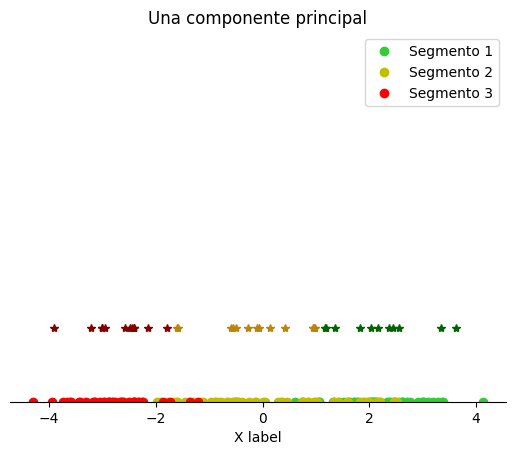

In [27]:
def graficar_1comp(A_train, segmentos_train, A_test, segmentos_test):

  #Escribimos la Matriz train en base al primer autovector
  Matriz_avec = matriz_base_avec(A_train, 1)

  #Separamos por segmentos
  s1, s2, s3= separar_en_segmentos(Matriz_avec, segmentos_train)


  #Graficamos los casos Train
  plt.plot(s1[:,0],[0]*len(s1),'o',linewidth=3,color= 'limegreen',label='Segmento 1')
  plt.plot(s2[:,0],[0]*len(s2),'o',linewidth=3,color= 'y',label='Segmento 2')
  plt.plot(s3[:,0],[0]*len(s3),'o',linewidth=3,color= 'r',label='Segmento 3')

  #Escribimos la Matriz test en base a los dos primeros autovectores
  Vinos_avec= vinos_base_avec(A_test, A_train,1)

  #Graficamos los casos Test
  estimado_1comp = segmentar_varios(A_test, 1, 3, A_train, segmentos_test, segmentos_train)

  #Elevamos un poco los puntos para poder corroborar dónde se ubican según nuestra estimación.
  #También utilizamos un color un poco más oscuro que el de los casos train.

  for i in range (len(Vinos_avec)):
    estimacion= estimado_1comp[i][1]
    if estimacion == 1:
      plt.plot(Vinos_avec[i][0],0.2,'*',linewidth=3,color= 'darkgreen')
    elif estimacion == 2:
      plt.plot(Vinos_avec[i][0],0.2,'*',linewidth=3,color= 'darkgoldenrod')
    else:
      plt.plot(Vinos_avec[i][0],0.2,'*',linewidth=3,color= 'maroon')

  ax = plt.subplot(111)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['top'].set_visible(False)


  plt.ylim(0,1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.xlabel('X label')
  plt.title('Una componente principal')
  plt.legend( )
  plt.show( )

graficar_1comp(A_train, segmentos_train, A_test, segmentos_test)

In [28]:
# (Ytest, Yestimado)
estimacion_1comp= segmentar_varios(A_test, 1, 3, A_train, segmentos_test, segmentos_train)
print(estimacion_1comp)

[(1.0, 1.0), (1.0, 1.0), (1.0, 2.0), (1.0, 1.0), (1.0, 1.0), (1.0, 2.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 2.0), (1.0, 1.0), (2.0, 2.0), (2.0, 2.0), (2.0, 1.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 1.0), (2.0, 2.0), (2.0, 3.0), (2.0, 2.0), (2.0, 3.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0)]


- CASO CON DOS COMPONENTES PRINCIPALES

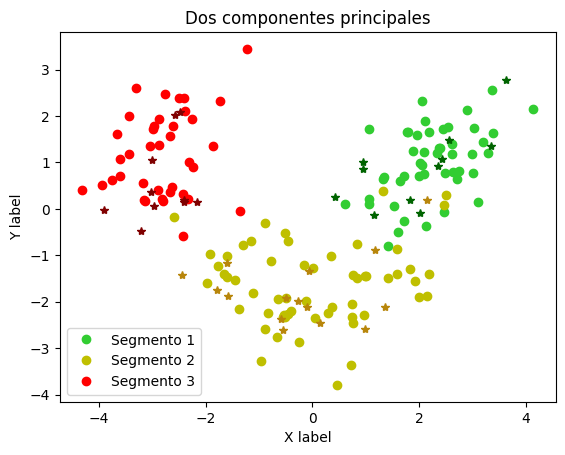

In [29]:
def graficar_2comp(A_train, segmentos_train, A_test, segmentos_test):
  #Escribimos la Matriz train en base a los dos primeros autovectores
  Matriz_avec = matriz_base_avec(A_train, 2)

  #Separamos por segmentos
  s1, s2, s3= separar_en_segmentos(Matriz_avec, segmentos_train)

  #Graficamos los casos Train
  plt.plot(s1[:,0], s1[:,1],'o',linewidth=3,color= 'limegreen',label='Segmento 1')
  plt.plot(s2[:,0], s2[:,1],'o',linewidth=3,color= 'y',label='Segmento 2')
  plt.plot(s3[:,0], s3[:,1],'o',linewidth=3,color= 'r',label='Segmento 3')

  #Escribimos la Matriz test en base a los dos primeros autovectores
  Vinos_avec= vinos_base_avec(A_test, A_train,2)

  #Graficamos los casos Test. Utilizamos un color un poco más oscuro que el de los casos train para que se noten
  estimado_2comp = segmentar_varios(A_test, 2, 3, A_train, segmentos_test, segmentos_train)

  for i in range (len(Vinos_avec)):
    estimacion= estimado_2comp[i][1]
    if estimacion == 1:
      plt.plot(Vinos_avec[i][0], Vinos_avec[i][1],'*',linewidth=3,color= 'darkgreen')
    elif estimacion == 2:
      plt.plot(Vinos_avec[i][0], Vinos_avec[i][1],'*',linewidth=3,color= 'darkgoldenrod')
    else:
      plt.plot(Vinos_avec[i][0], Vinos_avec[i][1],'*',linewidth=3,color= 'maroon')

  plt.xlabel('X label')
  plt.ylabel('Y label')
  plt.title('Dos componentes principales')
  plt.legend( )
  plt.show( )

graficar_2comp(A_train, segmentos_train, A_test, segmentos_test)

In [30]:
# (Y_test, Y_estimado)
estimacion_2comp= segmentar_varios(A_test, 2, 3, A_train, segmentos_test, segmentos_train)
print(estimacion_2comp)


[(1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 2.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0)]


- CASO CON TRES COMPONENTES PRINCIPALES

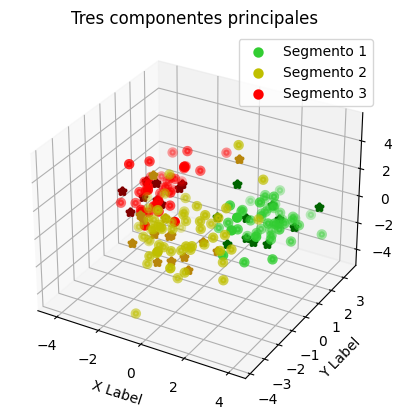

In [31]:
def graficar_3comp(A_train, segmentos_train, A_test, segmentos_test):
  #Escribimos la Matriz train en base a los tres primeros autovectores
  Matriz_avec = matriz_base_avec(A_train, 3)

  #Separamos por segmentos
  s1, s2, s3= separar_en_segmentos(Matriz_avec, segmentos_train)

  #Graficamos los casos Train
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.scatter(s1[:,0], s1[:,1], s1[:,2], marker='o',linewidth=3,color= 'limegreen',label='Segmento 1')
  ax.scatter(s2[:,0], s2[:,1], s2[:,2], marker='o',linewidth=3,color= 'y',label='Segmento 2')
  ax.scatter(s3[:,0], s3[:,1], s3[:,2], marker='o',linewidth=3,color= 'r',label='Segmento 3')

  #Escribimos la Matriz test en base a los tres primeros autovectores
  Vinos_avec= vinos_base_avec(A_test, A_train,3)

  #Graficamos los casos Test. Utilizamos un color un poco más oscuro que el de los casos train para que se noten
  estimado_3comp = segmentar_varios(A_test, 3, 3, A_train, segmentos_test, segmentos_train)

  for i in range (len(Vinos_avec)):
    estimacion= estimado_3comp[i][1]
    if estimacion == 1:
      ax.scatter(Vinos_avec[i][0], Vinos_avec[i][1], Vinos_avec[i][2], marker='*',linewidth=3,color= 'darkgreen')
    elif estimacion == 2:
      ax.scatter(Vinos_avec[i][0], Vinos_avec[i][1], Vinos_avec[i][2], marker='*',linewidth=3,color= 'darkgoldenrod')
    else:
      ax.scatter(Vinos_avec[i][0], Vinos_avec[i][1], Vinos_avec[i][2], marker='*',linewidth=3,color= 'maroon')



  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')
  plt.title('Tres componentes principales')
  plt.legend( )
  plt.show( )

graficar_3comp(A_train, segmentos_train, A_test, segmentos_test)

In [32]:
# (Y_test, Y_estimado)
estimacion_3comp=segmentar_varios(A_test, 3, 3, A_train, segmentos_test, segmentos_train)
print(estimacion_3comp)

[(1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 2.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (2.0, 2.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0), (3.0, 3.0)]


#### Conclusión

- En base a la Tabla Modelo PCA, estimamos que lo más óptimo es utilizar 2 componentes principales para las estimaciones.

- Ésto se debe a que el 3er componente aporta muy poco (11% aprox).



### C) Matriz de Confusión

--------------

- **INPUT**: Matriz A (sacada de función segmentar_varios)
- **OUTPUT**: Matriz de Confusión $C \in R^{3 x 3}$

In [33]:
def confusion(A):
  C = np.zeros((3, 3))
  #Creamos 3 listas para guardar las estimaciones obtenidas de 1, 2 y 3.
  lunos = []
  ldos = []
  ltres = []

  # Guardamos los valores en las listas.
  for i in range(len(A)):
    if (A[i][0] == 1):
      lunos.append(A[i][1])
    elif (A[i][0] == 2):
      ldos.append(A[i][1])
    else:
      ltres.append(A[i][1])

  # Armamos la matriz de confusión a partir de las filas
  # Por ej: en Fila 1 agregamos:
        #   -> Col 1: los segmento 1 estimados como segmento 1
        #   -> Col 2: los segmento 1 estimados como segmento 2
        #   -> Col 3: los segmento 1 estimados como segmento 3
  for i in lunos:
    if (i == 1):
      C[0, 0] += 1
    elif (i == 2):
      C[0, 1] += 1
    else:
      C[0, 2] += 1

  # Repetimos los mismos pasos para las otras filas (de segmento real 2 y segmento real 3)
  for i in ldos:
    if (i == 1):
      C[1, 0] += 1
    elif (i == 2):
      C[1, 1] += 1
    else:
      C[1, 2] += 1

  for r in ltres:
    if (r == 1):
      C[2, 0] += 1
    elif (r == 2):
      C[2, 1] += 1
    else:
      C[2, 2] += 1

  return C

In [34]:
print("1 Componente Principal \n",confusion(segmentar_varios(A_test, 1, 3, A_train, segmentos_test, segmentos_train)), "\n")
print("2 Componentes Principales \n",confusion(segmentar_varios(A_test, 2, 3, A_train, segmentos_test, segmentos_train)),"\n")
print("3 Componentes Principales \n",confusion(segmentar_varios(A_test, 3, 3, A_train, segmentos_test, segmentos_train)),"\n")
print("4 Componentes Principales \n",confusion(segmentar_varios(A_test, 4, 3, A_train, segmentos_test, segmentos_train)),"\n")

1 Componente Principal 
 [[ 9.  3.  0.]
 [ 2. 10.  2.]
 [ 0.  0. 10.]] 

2 Componentes Principales 
 [[11.  1.  0.]
 [ 0. 14.  0.]
 [ 0.  0. 10.]] 

3 Componentes Principales 
 [[11.  1.  0.]
 [ 0. 14.  0.]
 [ 0.  0. 10.]] 

4 Componentes Principales 
 [[11.  1.  0.]
 [ 0. 13.  1.]
 [ 0.  0. 10.]] 



#### Conclusión

- La matriz de Confusión nos muestra, fuera de la diagonal, todos los errores que obtuvimos en la estimación.

- Éstos errores deberían ir disminuyendo cada vez que utilizamos más componentes principales (n) para la estimación. Sin embargo, vemos que esta performance se reduce a partir de los 3 comp principales. Como vemos, utilizando 4 componentes empeora.

- En nuestro caso, vemos que lo ideal es utilizar 2 componentes principales.




### D) Prueba Adicional

- **Input:** lista de tuplas con estimación (SegmentoTest, SegmentoEstimado)
- **Output:** Porcentaje de Aciertos expresado en decimal

In [43]:
def accuracy (estimacion):
  positivo= 0
  negativo= 0
  total = len(estimacion)
  for i in range (total):
    if estimacion[i][0] == estimacion[i][1]:
      positivo += 1
    else:
      negativo += 1
  res = positivo / total
  return res

Realizamos cinco pruebas distintas para calcular el accuracy promedio.Para ello dividimos la base de datos de cinco forma distintas, utilizando la función splitDataset.

In [52]:
#PRUEBA 1
train_data1, train_lab1, test_data1, test_lab1 = splitDataset (np.transpose(A), np.array([segmentos]))
A_train1 = np.transpose(train_data1)
segmentos_train1 = train_lab1[0]
A_test1 = np.transpose(test_data1)
segmentos_test1 = test_lab1[0]


#PRUEBA 2
train_data2, train_lab2, test_data2, test_lab2 = splitDataset (np.transpose(A), np.array([segmentos]))
A_train2 = np.transpose(train_data2)
segmentos_train2 = train_lab2[0]
A_test2 = np.transpose(test_data2)
segmentos_test2 = test_lab2[0]

#PRUEBA 3
train_data3, train_lab3, test_data3, test_lab3 = splitDataset (np.transpose(A), np.array([segmentos]))
A_train3 = np.transpose(train_data3)
segmentos_train3 = train_lab3[0]
A_test3 = np.transpose(test_data3)
segmentos_test3 = test_lab3[0]

#PRUEBA 4
train_data4, train_lab4, test_data4, test_lab4 = splitDataset (np.transpose(A), np.array([segmentos]))
A_train4 = np.transpose(train_data4)
segmentos_train4 = train_lab4[0]
A_test4 = np.transpose(test_data4)
segmentos_test4 = test_lab4[0]

#PRUEBA 5
train_data5, train_lab5, test_data5, test_lab5 = splitDataset (np.transpose(A), np.array([segmentos]))
A_train5 = np.transpose(train_data5)
segmentos_train5 = train_lab5[0]
A_test5 = np.transpose(test_data5)
segmentos_test5 = test_lab5[0]




Realizamos las estimaciones para cada uno y calculamos cada acuracy

In [53]:
# PRUEBA 1
estimado_1comp1 = segmentar_varios(A_test1, 1, 3, A_train1, segmentos_test1, segmentos_train1)
accuracy_1comp1 = accuracy(estimado_1comp1)
estimado_2comp1 = segmentar_varios(A_test1, 2, 3, A_train1, segmentos_test1, segmentos_train1)
accuracy_2comp1 = accuracy(estimado_2comp1)
estimado_3comp1 = segmentar_varios(A_test1, 3, 3, A_train1, segmentos_test1, segmentos_train1)
accuracy_3comp1 = accuracy(estimado_3comp1)
estimado_4comp1 = segmentar_varios(A_test1, 4, 3, A_train1, segmentos_test1, segmentos_train1)
accuracy_4comp1 = accuracy(estimado_4comp1)

# PRUEBA 2
estimado_1comp2 = segmentar_varios(A_test2, 1, 3, A_train2, segmentos_test2, segmentos_train2)
accuracy_1comp2 = accuracy(estimado_1comp2)
estimado_2comp2 = segmentar_varios(A_test2, 2, 3, A_train2, segmentos_test2, segmentos_train2)
accuracy_2comp2 = accuracy(estimado_2comp2)
estimado_3comp2 = segmentar_varios(A_test2, 3, 3, A_train2, segmentos_test2, segmentos_train2)
accuracy_3comp2 = accuracy(estimado_3comp2)
estimado_4comp2 = segmentar_varios(A_test2, 4, 3, A_train2, segmentos_test2, segmentos_train2)
accuracy_4comp2 = accuracy(estimado_4comp2)

# PRUEBA 3
estimado_1comp3 = segmentar_varios(A_test3, 1, 3, A_train3, segmentos_test3, segmentos_train3)
accuracy_1comp3 = accuracy(estimado_1comp3)
estimado_2comp3 = segmentar_varios(A_test3, 2, 3, A_train3, segmentos_test3, segmentos_train3)
accuracy_2comp3 = accuracy(estimado_2comp3)
estimado_3comp3 = segmentar_varios(A_test3, 3, 3, A_train3, segmentos_test3, segmentos_train3)
accuracy_3comp3 = accuracy(estimado_3comp3)
estimado_4comp3 = segmentar_varios(A_test3, 4, 3, A_train3, segmentos_test3, segmentos_train3)
accuracy_4comp3 = accuracy(estimado_4comp3)

# PRUEBA 4
estimado_1comp4 = segmentar_varios(A_test4, 1, 3, A_train4, segmentos_test4, segmentos_train4)
accuracy_1comp4 = accuracy(estimado_1comp4)
estimado_2comp4 = segmentar_varios(A_test4, 2, 3, A_train4, segmentos_test4, segmentos_train4)
accuracy_2comp4 = accuracy(estimado_2comp4)
estimado_3comp4 = segmentar_varios(A_test4, 3, 3, A_train4, segmentos_test4, segmentos_train4)
accuracy_3comp4 = accuracy(estimado_3comp4)
estimado_4comp4 = segmentar_varios(A_test4, 4, 3, A_train4, segmentos_test4, segmentos_train4)
accuracy_4comp4 = accuracy(estimado_4comp4)

# PRUEBA 5
estimado_1comp5 = segmentar_varios(A_test5, 1, 3, A_train5, segmentos_test5, segmentos_train5)
accuracy_1comp5 = accuracy(estimado_1comp5)
estimado_2comp5 = segmentar_varios(A_test5, 2, 3, A_train5, segmentos_test5, segmentos_train5)
accuracy_2comp5 = accuracy(estimado_2comp5)
estimado_3comp5 = segmentar_varios(A_test5, 3, 3, A_train5, segmentos_test5, segmentos_train5)
accuracy_3comp5 = accuracy(estimado_3comp5)
estimado_4comp5 = segmentar_varios(A_test5, 4, 3, A_train5, segmentos_test5, segmentos_train5)
accuracy_4comp5 = accuracy(estimado_4comp5)


Armamos listas con los acurracy de cada una de las pruebas para cada uno de los casos (cantidad de componentes principales)


In [54]:
total_accuracy_1comp= [accuracy_1comp1,accuracy_1comp2,accuracy_1comp3,accuracy_1comp4,accuracy_1comp5]
total_accuracy_2comp= [accuracy_2comp1,accuracy_2comp2,accuracy_2comp3,accuracy_2comp4,accuracy_2comp5]
total_accuracy_3comp= [accuracy_3comp1,accuracy_3comp2,accuracy_3comp3,accuracy_3comp4,accuracy_3comp5]
total_accuracy_4comp= [accuracy_4comp1,accuracy_4comp2,accuracy_4comp3,accuracy_4comp4,accuracy_4comp5]


Caclulamos el promedio de los acurracy

- **Input:** lista de aciertos calculados
- **Output:** Promedio de los elementos de la lista



In [55]:
def promedio_acurracy(lista):
  n = len(lista)
  suma = 0
  for i in range (n):
    suma += lista[i]
  return suma/n

promedio_1comp= promedio_acurracy(total_accuracy_1comp)
promedio_2comp= promedio_acurracy(total_accuracy_2comp)
promedio_3comp= promedio_acurracy(total_accuracy_3comp)
promedio_4comp= promedio_acurracy(total_accuracy_4comp)

print("Promedio de Acurracy 1 componente principal:",promedio_1comp,"\n")
print("Promedio de Acurracy 2 componente principal:",promedio_2comp,"\n")
print("Promedio de Acurracy 3 componente principal:",promedio_3comp,"\n")
print("Promedio de Acurracy 4 componente principal:",promedio_4comp,"\n")

Promedio de Acurracy 1 componente principal: 0.8277777777777778 

Promedio de Acurracy 2 componente principal: 0.9444444444444443 

Promedio de Acurracy 3 componente principal: 0.961111111111111 

Promedio de Acurracy 4 componente principal: 0.95 



# CONCLUSIÓN FINAL




- Con este TP entendimos , en primer lugar, la importancia que tiene Normalizar los datos de entrada para evitar que los valores más altos afecten los cálculos (Proline).

- Una vez los datos normalizados, podemos calcular la **Matriz de Covarianza** de manera confiable y obtener sus autovalores y autovectores utilizando el **Método de la Potencia Extendido**.

- Los autovalores nos servirán para poder predecir, mediante el **Modelo PCA**, cuántos componentes principales serán suficientes para realizar las estimaciones o recomendaciones.

- Corroboramos nuestra implementación mediante gráficos y funciones para hasta cuatro componentes principales (excepto gráfico en este último caso).

- Logramos observar que, del **Modelo PCA**, podemos concluir que con tan sólo dos componentes principales obtenemos una buena estimación.


- Por último, esta misma experiencia se puede visualizar gracias a la **Matriz de Confusión** implementada, donde buscamos que sea lo más diagonal posible.

- Realizamos una prueba adicional, donde hicimos 5 nuevas divisiones de la base de datos, de forma aleatoria,en matrices Test y Train. Calculamos el procentaje de acierto de nuestra estimación para cada una de las pruebas, con 1, 2,3 y 4 componentes principales. Luego, calculamos un promedio de los porcentajes de acierto para 1,2,3 y 4 componentes principales. Pudimos observar, que la performance se eleva hasta la 3° componente principal, a partir de la cual desciende.


---

En conclusión, este método nos ayudará a predecir una recomendación óptima utilizando la menor cantidad de recursos posibles, de tal forma que resulte en un algoritmo eficiente. Sin embargo, podemos ver, que para esto, en la búsqueda de un modelo óptimo, se debe encontrar el equilibro adecuado en la selección del número de componentes. Vemos que si elegimos muy pocos componentes, por ejemplo 1 componente principal, podemos estar perdiendo información relevante para la recomendación. Por otro lado, si elegimos demasiados, en nuestras pruebas a partir de 4 componentes principales, podemos estar teniendo en cuenta información que resulta ser irrelevante y "ensucia" la recomendación.